# 3D_HOUSES

## Import all libraries

In [20]:
from glob import glob
from typing import Tuple, List
import natsort
import numpy as np
import matplotlib.pyplot as plt
from mayavi import mlab

import geopandas as gpd
import rasterio
import rioxarray as rxr
from shapely.geometry import Point, Polygon

%matplotlib inline

Notebook initialized with ipy backend.


## Global Variables

In [21]:
address = "Sint-Pietersplein%209,Gent"

DSM_path = "/Volumes/Samsung T7/DSM/**/*.tif"
DTM_path =  "/Volumes/Samsung T7/DTM/**/*.tif"

shp_paths = ["/Volumes/Samsung T7/CADASTRE DATA/Belgium_L72_2020/Bpn_CaBu.shp", "/Volumes/Samsung T7/CADASTRE DATA/Belgium_L72_2020/Bpn_ReBu.shp"]

## Create a dictionary of GTiff's paths and bounds

In [22]:
def load_data(DSM_path:str, DTM_path:str) -> dict:
    
    data = {}
    data['DSM_list'] = natsort.natsorted([file for file in glob(DSM_path, recursive=True)])
    data['DTM_list'] = natsort.natsorted([file for file in glob(DTM_path, recursive=True)])
    data['bounds'] = []
    
    for path in data['DSM_list']:
        with rasterio.open(path, driver="GTiff") as tif:
            data['bounds'].append(np.array(tif.bounds))

    return data

In [23]:
data = load_data(DSM_path, DTM_path)
data

{'DSM_list': ['/Volumes/Samsung T7/DSM/DHMVIIDSMRAS1m_k01/GeoTIFF/DHMVIIDSMRAS1m_k01.tif',
  '/Volumes/Samsung T7/DSM/DHMVIIDSMRAS1m_k02/GeoTIFF/DHMVIIDSMRAS1m_k02.tif',
  '/Volumes/Samsung T7/DSM/DHMVIIDSMRAS1m_k03/GeoTIFF/DHMVIIDSMRAS1m_k03.tif',
  '/Volumes/Samsung T7/DSM/DHMVIIDSMRAS1m_k04/GeoTIFF/DHMVIIDSMRAS1m_k04.tif',
  '/Volumes/Samsung T7/DSM/DHMVIIDSMRAS1m_k05/GeoTIFF/DHMVIIDSMRAS1m_k05.tif',
  '/Volumes/Samsung T7/DSM/DHMVIIDSMRAS1m_k06/GeoTIFF/DHMVIIDSMRAS1m_k06.tif',
  '/Volumes/Samsung T7/DSM/DHMVIIDSMRAS1m_k07/GeoTIFF/DHMVIIDSMRAS1m_k07.tif',
  '/Volumes/Samsung T7/DSM/DHMVIIDSMRAS1m_k15/GeoTIFF/DHMVIIDSMRAS1m_k15.tif',
  '/Volumes/Samsung T7/DSM/DHMVIIDSMRAS1m_k22/GeoTIFF/DHMVIIDSMRAS1m_k22.tif'],
 'DTM_list': ['/Volumes/Samsung T7/DTM/DHMVIIDTMRAS1m_k01/GeoTIFF/DHMVIIDTMRAS1m_k01.tif',
  '/Volumes/Samsung T7/DTM/DHMVIIDTMRAS1m_k02/GeoTIFF/DHMVIIDTMRAS1m_k02.tif',
  '/Volumes/Samsung T7/DTM/DHMVIIDTMRAS1m_k03/GeoTIFF/DHMVIIDTMRAS1m_k03.tif',
  '/Volumes/Samsung T7/DTM/

## Fetching the L_72 coordinates from the API with address

In [ ]:
def fetch_coord(address:str)  -> Point:
    pass

In [24]:
coord = Point(104994.91, 192612.04)

## Find the relevant GTiff file containing the coordinates

In [25]:
def find_tif(data:dict, coord:Point) -> Tuple[str]:
    x, y = coord.xy
    for tif_index, bounds in enumerate(data['bounds']):
        x_min, y_min, x_max, y_max = bounds
        if (x_min < x < x_max) and (y_min < y < y_max):
            return tif_index

In [26]:
tif_index = find_tif(data, coord)
tif_index

8

## Find the polygon containing the coordinates

In [27]:
def find_polygon(coord:Point, shp_paths:List[str]):

    for path in shp_paths:
        try:
            poly = gpd.read_file(path, mask=coord).geometry[0]
            break
        except:
            continue
    return poly

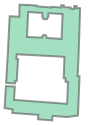

In [28]:
poly = find_polygon(coord, shp_paths)
poly

## Crop DSM & DTM

In [31]:
def crop_tif(data, tif_index, poly, shape_cut=False):
    
    DSM = rxr.open_rasterio(data['DSM_list'][tif_index],masked=True)
    DTM = rxr.open_rasterio(data['DTM_list'][tif_index],masked=True)

    left, bottom, right, top = poly.bounds
    DSM_clip = DSM.rio.clip_box(left, bottom, right, top)
    DTM_clip = DTM.rio.clip_box(left, bottom, right, top)

    if shape_cut:
        DSM_clip = DSM_clip.rio.clip([poly.__geo_interface__])
        DSM_clip = np.nan_to_num(DSM_clip, nan=0)

        DTM_clip = DTM_clip.rio.clip([poly.__geo_interface__])
        DTM_clip = np.nan_to_num(DTM_clip, nan=0)
    
    DSM.close()
    DTM.close()
    
    return DSM_clip, DTM_clip

In [33]:
DSM_clip, DTM_clip = crop_tif(data, tif_index, poly, shape_cut=True)

## Create CHM from DSM & DTM

In [13]:
def CHMer(DSM_clip, 
          DTM_clip):
    return DSM_clip - DTM_clip

In [14]:
CHM = CHMer(DSM_clip, DTM_clip)

## 3D Rendering

In [17]:
def render_3D(CHM_clip):
    arr = CHM_clip.squeeze().data
    arr = np.pad(arr, [(2, ), (2, )], mode='constant')
    mlab.figure(size=(640, 800), bgcolor=(0.16, 0.28, 0.46))
    surf = mlab.surf(arr)
    mlab.zlabel("Height")
    mlab.show()

In [18]:
render_3D(CHM)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\x80\x00\x00\x03 \x08\x02\x00\x00\x00<\xc4D.\x00\…

## 3D Rendering inline

In [ ]:
mlab.init_notebook()
def render_3D_inline(CHM_clip):
    arr = CHM_clip.squeeze().data
    arr = np.pad(arr, [(2, ), (2, )], mode='constant')
    mlab.figure(size=(640, 800), bgcolor=(0.16, 0.28, 0.46))
    surf = mlab.surf(arr)
    mlab.zlabel("Height")
    return surf
plot = render_3D_inline(CHM)
plot